<a href="https://colab.research.google.com/github/ankit-rathi/Data-Science-with-Python/blob/master/Nifty100_Buy_Sell_Signals_Latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

mypf = pd.read_csv('/content/drive/My Drive/data/stocks/Nifty100Scrips.csv')

#mypf = mypf[mypf['Nifty100'] == 1]

stock_n100 = mypf['Symbol'].unique()

exclude = ['CADILAHC','MMTC']

stock_n100 = mypf[~mypf['Symbol'].isin(exclude) ]['Symbol'].unique()

stock_ids = stock_n100

#mypf = mypf[mypf.Forecast.notnull()]
#stock_ids = mypf['Symbol'].unique()

stock_ids.sort()
#stock_ids

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# import necessary libraries 

%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib 
yfin.pdr_override()
import pandas_ta as ta

In [4]:
# function to compute stock attributes

def stock_prec_dev(stock_symbol, date):
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20 
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'    
    
    end_date = date.strftime('%Y-%m-%d')
    start_date = (date + datetime.timedelta(days=-365*3)).strftime('%Y-%m-%d')
    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    #start = datetime.datetime(*map(int, start_date.split('-')))
    #end = datetime.datetime(*map(int, end_date.split('-'))) 
    stock_df = yfin.Ticker(stock_symbol).history(period='3y')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    #stock_df = pd.DataFrame(stock_df) # convert Series object to dataframe 
    #stock_df.columns = {'Close Price'} # assign new colun name
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows 

    # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg
    mid_window_col = str(mid_window) + '_' + moving_avg
    long_window_col = str(long_window) + '_' + moving_avg  

    #print(stock_df)

    # Create short exponential moving average column
    stock_df[short_window_col] = round(stock_df['Close'].rolling(window = short_window, min_periods = 1).mean(),0)

    stock_df[mid_window_col] = round(stock_df['Close'].rolling(window = mid_window, min_periods = 1).mean(),0)     

    #stock_df['RSI'] = round(talib.RSI(stock_df['Close Price'], timeperiod=14),0)

    # Create a long exponential moving average column
    stock_df[long_window_col] = round(stock_df['Close'].rolling(window = long_window, min_periods = 1).mean(),0)
    stock_df['Stock'] = stock_symbol
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    #stock_df['200_SMA_Lag10'] = stock_df['200_SMA'].shift(10)
    #stock_df['Slope%_200'] = round((stock_df['200_SMA'] - stock_df['200_SMA_Lag10'])*100/stock_df['200_SMA'],2)
    #stock_df['50_SMA_Lag5'] = stock_df['50_SMA'].shift(5)
    #stock_df['Slope%_50'] = round((stock_df['50_SMA'] - stock_df['50_SMA_Lag5'])*100/stock_df['50_SMA'],2)
    #stock_df['Max'] = round(max(stock_df['Close']),0)
    #stock_df['Min'] = round(min(stock_df['Close']),0)    
    #stock_df['Dev%_Max'] = round((stock_df['Close Price'] - stock_df['Max'])*100/stock_df['Max'],2)
    #stock_df['Dev%_Min'] = round((stock_df['Close Price'] - stock_df['Min'])*100/stock_df['Min'],2)
    #stock_df['Premium%'] = round((stock_df['Close']-stock_df['Min'])*100/(stock_df['Max']-stock_df['Min']),2)
    #stock_df['Discount%'] = round((stock_df['Max']-stock_df['Close'])*100/(stock_df['Max']-stock_df['Min']),2)
    #stock_df.ta.macd(close='Close', fast=12, slow=26, append=True)
    #stock_df['Trend'] = 'Down'
    #stock_df.loc[stock_df['MACD_12_26_9'] - stock_df['MACDs_12_26_9'] > 10, 'Trend'] = 'Up'
    #stock_df.ta.eom(append=True)    
    #stock_df.ta.rsi(append=True)
    #stock_df.rename(columns={'EOM_14_100000000':'EOM'}, inplace=True)
    #stock_df.rename(columns={'RSI_14':'RSI'}, inplace=True)
    stock_df['Close'] = round(stock_df['Close'],0) 
    #stock_df['EOM'] = round(stock_df['EOM'],0) 
    #stock_df['EOM'] = '-ve'
    #stock_df.loc[stock_df['EOM_14_100000000'] > 0, 'EOM'] = '+ve'    
    #stock_df['RSI'] = round(stock_df['RSI'],0) 
    stock_df.drop(['Open', 'Low', 'High', 'Volume' #,'20_SMA'
                   #'MACD_12_26_9','MACDh_12_26_9','MACDs_12_26_9','EOM_14_100000000'
                   ], axis=1, inplace=True)   
    
    return stock_df

def get_stock_buy_sell(stock_symbol):
    date = (datetime.date.today() + datetime.timedelta(days=0))    
    df_prec_dev = stock_prec_dev(stock_symbol, date)
    df_prec_dev['Signal'] = 0.0  
    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] < df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] < df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] < df_prec_dev['200_SMA'])), 1.0, df_prec_dev['Signal']) 

    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] > df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] > df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] > df_prec_dev['200_SMA'])), -1.0, df_prec_dev['Signal']) 

    df_prec_dev['Position'] = df_prec_dev['Signal'].diff()
    
    df_pos = df_prec_dev[(df_prec_dev['Position'] >= 1) | (df_prec_dev['Position'] <= -1)]    
    df_pos = df_pos[df_pos['Signal'] != 0]
    df_pos['Prev_Signal'] = df_pos['Signal'].shift(1)
    df_pos = df_pos[df_pos['Signal'] != df_pos['Prev_Signal']]
    df_pos.drop('Prev_Signal', axis=1, inplace=True)
    
    return df_pos.tail(1)

def get_daily_buy_sell():
    df_buy_sell = pd.DataFrame()
    for stock_id in stock_ids:
        df_tmp = get_stock_buy_sell(stock_id+'.NS')
        df_buy_sell = df_buy_sell.append(df_tmp)
        
    df_buy_sell['Position'] = df_buy_sell['Position'].apply(lambda x: 'Buy' if x >= 1 else 'Sell')    
    return df_buy_sell.sort_index()

def plot_stock_buy_sell(stock_symbol):
    date = (datetime.date.today() + datetime.timedelta(days=0))    
    df_prec_dev = stock_prec_dev(stock_symbol, date)
    df_prec_dev['Signal'] = 0.0  
    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] < df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] < df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] < df_prec_dev['200_SMA'])), 1.0, df_prec_dev['Signal']) 

    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] > df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] > df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] > df_prec_dev['200_SMA'])), -1.0, df_prec_dev['Signal']) 

    df_prec_dev['Position'] = df_prec_dev['Signal'].diff()

    # plot close price, short-term and long-term moving averages
    plt.figure(figsize = (20,10))
    plt.tick_params(axis = 'both', labelsize = 14)
    df_prec_dev['Close'].plot(color = 'k', lw = 1, label = 'Close')  
    #stock_df[short_window_col].plot(color = 'g', lw = 1, label = short_window_col)
    df_prec_dev['20_SMA'].plot(color = 'g', lw = 1, label = '20_SMA')
    df_prec_dev['50_SMA'].plot(color = 'm', lw = 1, label = '50_SMA')
    df_prec_dev['200_SMA'].plot(color = 'b', lw = 1, label = '200_SMA') 

    df_pos = df_prec_dev[(df_prec_dev['Position'] >= 1) | (df_prec_dev['Position'] <= -1)]    
    df_pos = df_pos[df_pos['Signal'] != 0]
    df_pos['Prev_Signal'] = df_pos['Signal'].shift(1)
    df_pos = df_pos[df_pos['Signal'] != df_pos['Prev_Signal']]
    df_pos.drop('Prev_Signal', axis=1, inplace=True)


    # plot 'buy' signals
    plt.plot(df_pos[df_pos['Position'] >= 1].index, 
          df_pos['Close'][df_pos['Position'] >= 1], 
          '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

    # plot 'sell' signals
    plt.plot(df_pos[df_pos['Position'] <= -1].index, 
          df_pos['Close'][df_pos['Position'] <= -1], 
          'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')

    plt.ylabel('Price in ₹', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.title(stock_symbol + '  : Buy/Sell Signal', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()

    display_table = True

    if display_table == True:
      print(stock_symbol)
      df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x >= 1 else 'Sell')
      print(tabulate(df_pos, headers = 'keys', tablefmt = 'psql'))

df_daily_buy_sell = get_daily_buy_sell()

In [5]:
df_daily_buy_sell[df_daily_buy_sell['Position'] == 'Buy'].tail(20)

,Close,20_SMA,50_SMA,200_SMA,Stock,Dev%_200,Signal,Position
Date,,,,,,,,
2023-02-27 00:00:00+05:30,2438.0,2539.0,2615.0,2618.0,HEROMOTOCO.NS,-6.89,1.0,Buy
2023-02-27 00:00:00+05:30,425.0,446.0,464.0,466.0,SUNTV.NS,-8.87,1.0,Buy
2023-02-27 00:00:00+05:30,330.0,355.0,448.0,451.0,AMBUJACEM.NS,-26.85,1.0,Buy
2023-02-28 00:00:00+05:30,489.0,501.0,554.0,556.0,HDFCLIFE.NS,-12.09,1.0,Buy
2023-03-02 00:00:00+05:30,146.0,158.0,165.0,166.0,TIPSINDLTD.NS,-12.19,1.0,Buy
2023-03-02 00:00:00+05:30,886.0,989.0,1036.0,1039.0,CIPLA.NS,-14.68,1.0,Buy
2023-03-02 00:00:00+05:30,1098.0,1145.0,1212.0,1214.0,SBILIFE.NS,-9.59,1.0,Buy
2023-03-06 00:00:00+05:30,1797.0,1850.0,1978.0,1983.0,HDFCAMC.NS,-9.40,1.0,Buy
2023-03-08 00:00:00+05:30,532.0,533.0,547.0,549.0,DABUR.NS,-3.12,1.0,Buy


In [6]:
df_daily_buy_sell[df_daily_buy_sell['Position'] == 'Sell'].tail(20)

,Close,20_SMA,50_SMA,200_SMA,Stock,Dev%_200,Signal,Position
Date,,,,,,,,
2022-12-15 00:00:00+05:30,2015.0,1933.0,1838.0,1834.0,INDIGO.NS,9.87,-1.0,Sell
2022-12-27 00:00:00+05:30,471.0,460.0,437.0,435.0,HINDALCO.NS,8.28,-1.0,Sell
2022-12-30 00:00:00+05:30,143.0,140.0,134.0,133.0,ONGC.NS,7.48,-1.0,Sell
2023-01-05 00:00:00+05:30,79.0,77.0,74.0,73.0,IOC.NS,8.36,-1.0,Sell
2023-01-11 00:00:00+05:30,352.0,337.0,328.0,327.0,BPCL.NS,7.80,-1.0,Sell
2023-01-18 00:00:00+05:30,243.0,241.0,233.0,232.0,HINDPETRO.NS,4.87,-1.0,Sell
2023-01-18 00:00:00+05:30,90.0,84.0,83.0,80.0,SAIL.NS,12.05,-1.0,Sell
2023-01-23 00:00:00+05:30,3415.0,3272.0,3268.0,3208.0,TCS.NS,6.45,-1.0,Sell
2023-01-24 00:00:00+05:30,98.0,94.0,92.0,91.0,GAIL.NS,8.00,-1.0,Sell


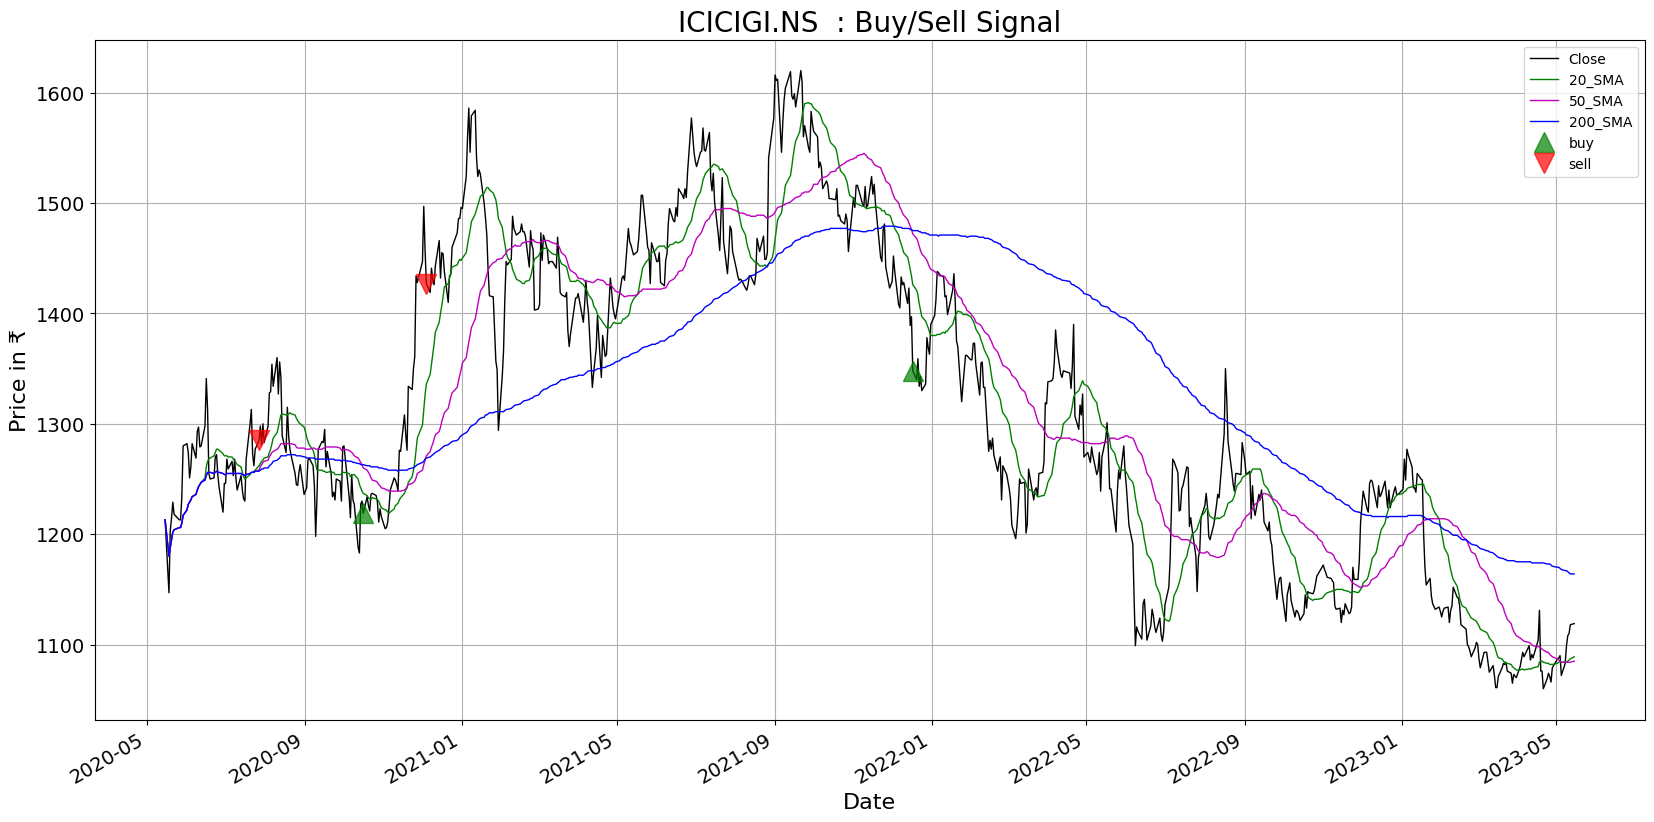

ICICIGI.NS
+---------------------------+---------+----------+----------+-----------+------------+------------+----------+------------+
| Date                      |   Close |   20_SMA |   50_SMA |   200_SMA | Stock      |   Dev%_200 |   Signal | Position   |
|---------------------------+---------+----------+----------+-----------+------------+------------+----------+------------|
| 2020-07-27 00:00:00+05:30 |    1285 |     1262 |     1258 |      1257 | ICICIGI.NS |       2.26 |       -1 | Sell       |
| 2020-10-16 00:00:00+05:30 |    1219 |     1237 |     1260 |      1263 | ICICIGI.NS |      -3.49 |        1 | Buy        |
| 2020-12-04 00:00:00+05:30 |    1427 |     1336 |     1271 |      1269 | ICICIGI.NS |      12.44 |       -1 | Sell       |
| 2021-12-17 00:00:00+05:30 |    1348 |     1426 |     1472 |      1475 | ICICIGI.NS |      -8.63 |        1 | Buy        |
+---------------------------+---------+----------+----------+-----------+------------+------------+----------+-----------

In [8]:
stock_symbol = 'ICICIGI.NS'
plot_stock_buy_sell(stock_symbol)